In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# To simulate a tennis match from scratch, first you must simulate the universe.
# Or, in my case, I start from the simplest unit of a tennis match, the point.
# first_serve is a bool which is true if the server successfully hits a first serve
# fsw is the server's observed first service win percentage
# ssw is the server's observed second service win percentage

def simulate_point(first_serve, fsw, ssw):
    return (fsw if first_serve else ssw) > npr.rand()

In [3]:
%%time

simulate_point(0.5 > npr.rand(), 0.5, 0.5)

CPU times: user 32 µs, sys: 119 µs, total: 151 µs
Wall time: 353 µs


False

In [4]:
# The next smallest unit in a tennis match is the game. 
# In tennis, the players both start at 0.
# After winning a point, a player goes from 0 --> 15 --> 30 --> 40 --> game won.
# However, if the game is tied at 40-40, then the game is considered at deuce.
# From deuce, whichever player wins 2 straight points wins the game. This state can last indefinitely.
# fsp is the server's observed first serve percentage.
# pw and pl are the points won and lost by the server.
# From this point on, the functions will keep track of the total points won and lost by the server.
def simulate_deuce(fsp, fsw, ssw, pw, pl):
    # A deuce can theoretically last forever
    while True:
        points_won = 0
        for _ in range(2):
            points_won += simulate_point(fsp > npr.rand(), fsw, ssw)
        if points_won == 2:
            return (True, pw + 2, pl)
        elif points_won == 0:
            return (False, pw, pl + 2)
        else:
            pw += 1
            pl += 1
            

# To simulate a game, I first simulate the minimum required points.
# I then return any game deciding scores and continue the simulation as required.
# By doing this I never simulate a point that would not be played in a real game.
# fsp is the server's observed first serve percentage.
def simulate_game(fsp, fsw, ssw):
    points_won = 0
     # 4 is the minimum number of points to decide a game.
    for _ in range(4):
        points_won += simulate_point(fsp > npr.rand(), fsw, ssw)
    
    # Game won after 40-0
    if points_won == 4:
        return (True, 4, 0)
    # Game lost after 0-40
    elif points_won == 0:
        return (False, 0, 4)
    # 30-30 is identical to Deuce
    elif points_won == 2:
        return simulate_deuce(fsp, fsw, ssw, 2, 2)
    
    # Scenarios remaining: 40-15 and 15-40
    points_won += simulate_point(fsp > npr.rand(), fsw, ssw)

    # Game won after 40-15
    if points_won == 4:
        return (True, 4, 1)
    # Game lost after 15-40
    elif points_won == 1:
        return (False, 1, 4)
        
    # Scenarios remaining: 40-30 and 30-40
    points_won += simulate_point(fsp > npr.rand(), fsw, ssw)
    # Game won after 40-30
    if points_won == 4:
        return (True, 4, 2)
    # Game lost after 30-40
    elif points_won == 2:
        return (False, 2, 4)
    # Deuce
    else:
        return simulate_deuce(fsp, fsw, ssw, 3, 3)

In [5]:
%%time

# Games with long deuces may take longer.
simulate_game(0.5, 0.5, 0.5)

CPU times: user 81 µs, sys: 4 µs, total: 85 µs
Wall time: 102 µs


(True, 4, 2)

In [6]:
# Before I can simulate a set properly, I must be able to simulate the tiebreak.
# When a set is tied at 6 games apiece, a tiebreak is played (There are exceptions to this at Grand Slam events)
# A tiebreak is basically a long game, with 7 points as the minimum threshold for victory instead of 4.
# However, the players switch serves on every odd point.

# At 5-5 or 6-6 in a tiebreak, a deuce-like scenario is created.
# Both players serve once each. In real match the order would matter but has no practical effect here.
# *_(p/o) the p and o stand for player and opponent.
def simulate_tiebreak_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw, pl):
    # A tiebreak can theoretically last forever.
    while True:
        points_won = 0
        
        points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
        # When the opponent serves, the result of the simulated point is negated.
        points_won += not simulate_point(fsp_o > npr.rand(), fsw_o, ssw_o)
        
        if points_won == 2:
            return (True, pw + 2, pl)
        elif points_won == 0:
            return (False, pw, pl + 2) 
        else:
            pw += 2
            pl += 2

# I have continued the "unrolled loop" approach, as despite being more verbose it performs well.
# *_(p/o) the p and o stand for player and opponent. The player serves first.
def simulate_tiebreak(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw, pl):
    points_won = 0
    
    # 7 is the minimum number of points to decide a tiebreak.
    # In the first 7 points, the player serves 3 times to the opponents 4
    for _ in range(3):
        points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
    # When the opponent serves, the result of the simulated point is negated.
    for _ in range(4):
        points_won += not simulate_point(fsp_o > npr.rand(), fsw_o, ssw_o)
        
    # Tiebreak won after 7-0
    if points_won == 7:
        return (True, pw + 7, pl)
    # Tiebreak lost after 0-7
    elif points_won == 0:
        return (False, pw, pl + 7)
    
    # Scenarios remaining: 6-1, 5-2, 4-3, 3-4, 2-5, 1-6
    # The player serves next.
    points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
    
    # Tiebreak won after 7-1
    if points_won == 7:
        return (True, pw + 7, pl + 1)
    # Tiebreak lost after 1-7
    elif points_won == 1:
        return (False, pw + 1, pl + 7)
    
    # Scenarios remaining: 6-2, 5-3, 4-4, 3-5, 2-6
    # The player serves next.
    points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
    
    # Tiebreak won after 7-2
    if points_won == 7:
        return (True, pw + 7, pl + 2)
    # Tiebreak lost after 2-7
    elif points_won == 2:
        return (False, pw + 2, pl + 7)
    
    # Scenarios remaining: 6-3, 5-4, 4-5, 3-6
    # The opponent serves next
    points_won += not simulate_point(fsp_o > npr.rand(), fsw_o, ssw_o)
    
    # Tiebreak won after 7-3
    if points_won == 7:
        return (True, pw + 7, pl + 3)
    # Tiebreak lost after 3-7
    elif points_won == 3:
        return (False, pw + 3, pl + 7)
    # At 5-5, the tiebreak is in a state similar to deuce.
    elif points_won == 5:
        return simulate_tiebreak_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw + 5, pl + 5)
    
    # Scenarios remaining: 6-4, 4-6
    # The opponent serves next
    points_won += not simulate_point(fsp_o > npr.rand(), fsw_o, ssw_o)
    
    # Tiebreak won after 7-4
    if points_won == 7:
        return (True, pw + 7, pl + 4)
    # Tiebreak lost after 4-7
    elif points_won == 4:
        return (False, pw + 4, pl + 7)
    # Scenarios remaining: 6-5, 5-6
    # The player serves next
    points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
    
    # Tiebreak won after 7-5
    if points_won == 7:
        return (True, pw + 7, pl + 5)
    # Tiebreak lost after 5-7
    elif points_won == 5:
        return (False, pw + 5, pl + 7)
    # Scenarios remaining: 6-6, which is a deuce situation
    else:
        return simulate_tiebreak_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw + 6, pw + 6)

In [7]:
%%time

simulate_tiebreak(.5, .5, .5, .5, .5, .5, 0, 0)

CPU times: user 48 µs, sys: 1 µs, total: 49 µs
Wall time: 53.9 µs


(False, 4, 7)

In [8]:
# The biggest sub-unit of a tennis match is the set.
# Each set acts like a tiebreak, with points replaced by games.
# A player must win 6 games to win a set, and with two games or more than the opponent.
# In the event of a tie at 6 games apiece, a tiebreak is played.
# Scorelines of 7-5 are also possible, and can only occur from 5 games apiece.
# The players switch serves each game. 
# In the tiebreak, the player who returned in the previous game serves first.
def simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o):
    games_won = 0
    points_won = 0
    points_lost = 0
    # 6 is the minimum number of games to decide a set.
    # In the first 6 games, each player serves 3 times.
    for i in range(3):
        (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
        games_won += game_result
        points_won += pw
        points_lost += pl
        
        (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
        games_won += not game_result
        points_won += pl
        points_lost += pw
        
    # Set won after 6-0
    if games_won == 6:
        return (True, points_won, points_lost, 6)
    # Set lost after 0-6
    elif games_won == 0:
        return (False, points_won, points_lost, 6)
    
    # Scenarios remaining: 5-1, 4-2, 3-3, 2-4, 1-5
    # The player serves next.
    (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
    games_won += game_result
    points_won += pw
    points_lost += pl
    
    # Set won after 6-1
    if games_won == 6:
        return (True, points_won, points_lost, 7)
    # Set lost after 1-6
    elif games_won == 1:
        return (False, points_won, points_lost, 7)
    
    # Scenarios remaining: 5-2, 4-3, 3-4, 2-5
    # The opponent serves next.
    (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
    games_won += not game_result
    points_won += pl
    points_lost += pw
    
    # Set won after 6-2
    if games_won == 6:
        return (True, points_won, points_lost, 8)
    # Set lost after 2-6
    elif games_won == 2:
        return (False, points_won, points_lost, 8)
    
    # Scenarios remaining: 5-3, 4-4, 3-5
    # The player serves next.
    (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
    games_won += game_result
    points_won += pw
    points_lost += pl
    
    # Set won after 6-3
    if games_won == 6:
        return (True, points_won, points_lost, 9)
    # Set lost after 3-6
    elif games_won == 3:
        return (False, points_won, points_lost, 9)
    
    # Scenarios remaining: 5-4, 4-5
    # The opponent serves next.
    (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
    games_won += not game_result
    points_won += pl
    points_lost += pw
    
    # Set won after 6-4
    if games_won == 6:
        return (True, points_won, points_lost, 10)
    # Set lost after 4-6
    elif games_won == 4:
        return (False, points_won, points_lost, 10)
    
    # Scenarios remaining: 5-5
    # Neither player can win on the next game, so 2 games are simulated
    (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
    games_won += game_result
    points_won += pw
    points_lost += pl
    
    (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
    games_won += not game_result
    points_won += pl
    points_lost += pw
    
    # Set won after 7-5
    if games_won == 7:
        return (True, points_won, points_lost, 12)
    # Set lost after 5-7
    elif games_won == 5:
        return (False, points_won, points_lost, 12)
    # Tied at 6-6, so go to a tiebreak
    else:
        return (*simulate_tiebreak(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, points_won, points_lost), 13)

In [9]:
%%time

simulate_set(.5, .5, .5, .5, .5, .5)

CPU times: user 390 µs, sys: 293 µs, total: 683 µs
Wall time: 378 µs


(True, 40, 33, 12)

In [10]:
# The end is finally in sight. 
# Depending on the tournament, matches may be best of 3 or 5 sets. 
# For now, I will focus only on simulating 3 set matches.
def simulate_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o):
    sets_won = 0
    points_won = 0
    points_lost = 0
    games_played = 0
    
    # Before each match, a coin is tossed to determine who serves first.
    coin_toss = npr.rand() > 0.5
    # First set
    if coin_toss:
        (set_result, pw, pl, games) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
    else:
        (set_result, pw, pl, games) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games
        
    # Second set
    # The server is instead determined by the total games played in the previous sets.
    # If total games is even, then the serve order stays the same.
    if (games_played % 2 == 0 and coin_toss) or (games_played % 2 == 1 and not coin_toss):
        (set_result, pw, pl, games) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
    else:
        (set_result, pw, pl, games) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games

        
    # If the score is 2-0 or 0-2, return with the results.
    if sets_won == 2:
        return (True, points_won, points_lost, games_played)
    elif sets_won == 0:
        return (False, points_won, points_lost, games_played)
       
    # Otherwise, simulate the deciding set              
    if (games_played % 2 == 0 and coin_toss) or (games_played % 2 == 1 and not coin_toss):
        (set_result, pw, pl, games) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
    else:
        (set_result, pw, pl, games) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games
                
    # Whether the score is 2-1 or 1-2, return with the results.
    if sets_won == 2:
        return (True, points_won, points_lost, games_played)
    else:
        return (False, points_won, points_lost, games_played)

In [11]:
%%time

simulate_match(.5, .5, .5, .5, .5, .5)

CPU times: user 414 µs, sys: 5 µs, total: 419 µs
Wall time: 591 µs


(False, 103, 111, 30)

In [12]:
def bootstrap_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, n=1):
    results = np.empty(n, dtype=object)
    
    for i in range(n):
        results[i] = simulate_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
    
    return results

In [13]:
%%time

bootstrap_match(.5, .5, .5, .5, .5, .5, 10000)

CPU times: user 1.89 s, sys: 17.7 ms, total: 1.91 s
Wall time: 2.06 s


array([(True, 72, 49, 14), (True, 80, 77, 24), (True, 63, 40, 16), ...,
       (False, 43, 64, 17), (True, 101, 95, 27), (False, 67, 86, 22)],
      dtype=object)

In [32]:
bootstraps = pd.DataFrame.from_records(bootstrap_match(.64, .72, .58, .6, .75, .52, 10000),
                            columns=['result', 'points_won', 'points_lost', 'games'])

In [33]:
bootstraps.result.sum() / bootstraps.result.size

0.5579

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


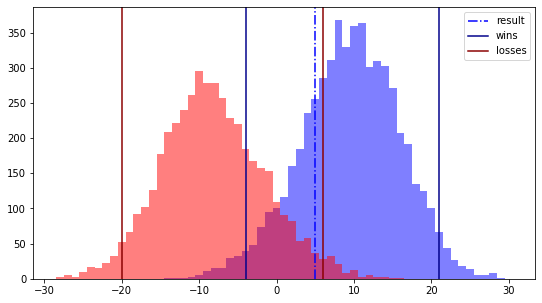

In [68]:
plt.rcParams['figure.figsize'] = [9, 5]

bootstraps['points_diff'] = bootstraps.points_won - bootstraps.points_lost
bootstraps['points_won_percentage'] = bootstraps.points_won / (bootstraps.points_won + bootstraps.points_lost)
wins = bootstraps[bootstraps.result == True]
losses = bootstraps[bootstraps.result == False]

confidence_wins = np.percentile(wins.points_diff, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_diff, [2.5, 97.5])

bins = np.arange(np.ptp(bootstraps.points_diff) + 1) - abs(bootstraps.points_diff.min()) - 0.5
_ = plt.hist(wins.points_diff, bins=bins, color='blue', alpha=0.5)
_ = plt.hist(losses.points_diff, bins=bins, color='red', alpha=0.5)


_ = plt.axvline(108 - 103, linestyle='-.', color='blue', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='-', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='-', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='-', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='-', color='darkred')

_ = plt.legend()

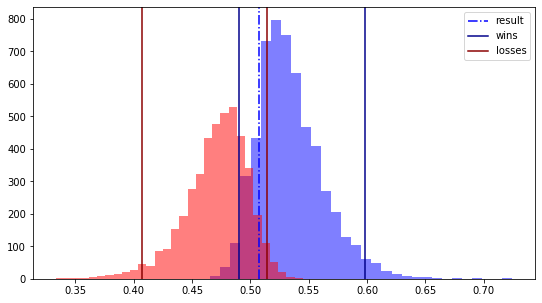

In [70]:
plt.rcParams['figure.figsize'] = [9, 5]

confidence_wins = np.percentile(wins.points_won_percentage, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_won_percentage, [2.5, 97.5])

_ = plt.hist(wins.points_won_percentage, bins=30, color='blue', alpha=0.5)
_ = plt.hist(losses.points_won_percentage, bins=30, color='red', alpha=0.5)

_ = plt.axvline(108/213, linestyle='-.', color='blue', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='-', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='-', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='-', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='-', color='darkred')

plt.legend()

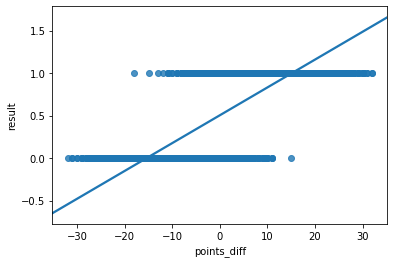

In [18]:
_ = sns.regplot(bootstraps.points_diff, bootstraps.result)

In [86]:
matches = pd.read_csv('Resources/tennis_clean/atp_top_100_matches.csv',
                      index_col=['player_id', 'tournament_id', 'match_id'],
                      parse_dates=['tournament_date'])
matches['points_diff'] = matches.points_won - (matches.points - matches.points_won)

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


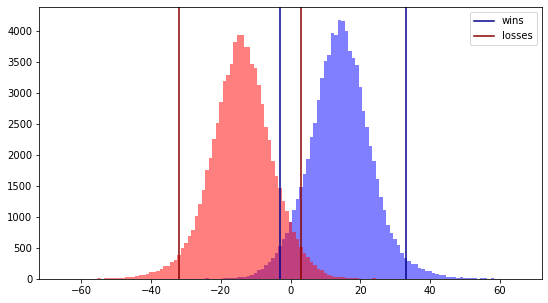

In [87]:
wins = matches[matches.result == 'W']
losses = matches[matches.result == 'L']

confidence_wins = np.nanpercentile(wins.points_diff, [2.5, 97.5])
confidence_losses = np.nanpercentile(losses.points_diff, [2.5, 97.5])

bins = np.arange(np.ptp(matches.points_diff) + 1) - abs(matches.points_diff.min()) - 0.5
_ = plt.hist(wins.points_diff, bins=bins, color='blue', alpha=0.5)
_ = plt.hist(losses.points_diff, bins=bins, color='red', alpha=0.5)

_ = plt.axvline(confidence_wins[0], linestyle='-', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='-', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='-', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='-', color='darkred')

_ = plt.legend()

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


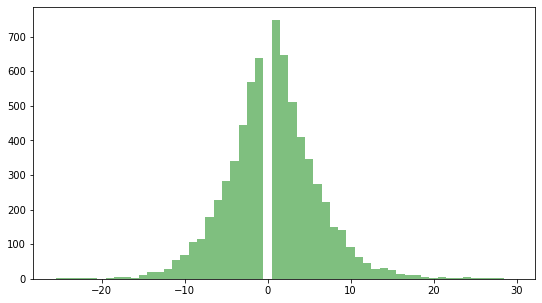

In [142]:
odd_matches = matches[(matches.best_of == 3) &
                      ((matches.points_diff < 0) & (matches.result == 'W')) | 
                      ((matches.points_diff > 0) & (matches.result == 'L'))]
odd_matches[['points_diff', 'result']]

bins = np.arange(np.ptp(odd_matches.points_diff) + 1) - abs(odd_matches.points_diff.min()) - 0.5
_ = plt.hist(odd_matches.points_diff, bins=bins, color='green', alpha=0.5)

In [143]:
odd_wins = odd_matches[odd_matches.points_diff < 0]
odd_losses = odd_matches[odd_matches.points_diff > 0]

odd_wins = odd_wins[~((odd_wins.score.str.contains('RET')) | (odd_wins.score.str.contains('DEF')))]
odd_wins.sort_values('points_won_percentage')[['player_name', 'score', 'points_diff', 'points_won_percentage']].head()

,,,player_name,score,points_diff,points_won_percentage
player_id,tournament_id,match_id,,,,
104312,2006-573,6.0,Andreas Seppi,6-2 6-2,-23.0,0.373626
100529,1991-375,20.0,Kevin Curren,6-1 6-2,-24.0,0.377551
105028,2008-315,3.0,Jesse Levine,6-3 6-1,-21.0,0.387097
105373,2015-339,16.0,Martin Klizan,1-6 7-6(6) 7-6(7),-25.0,0.442922
104098,2011-440,29.0,Dmitry Tursunov,6-3 7-6(1),-15.0,0.445255


In [152]:
lucky_win = odd_wins.loc[104312 ,'2006-573', 6.0]

fsp_p = lucky_win.first_serve_percentage
fsw_p = lucky_win.first_serves_won_percentage 
ssw_p = lucky_win.second_serves_won_percentage
fsp_o = (lucky_win.first_serve_return_points_won / lucky_win.first_serve_return_points_won_percentage) / lucky_win.return_points
fsw_o = 1 - lucky_win.first_serve_return_points_won_percentage
ssw_o = 1 - lucky_win.second_serve_return_points_won_percentage

bootstraps = pd.DataFrame.from_records(bootstrap_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, 10000),
                                       columns=['result', 'points_won', 'points_lost', 'games'])

bootstraps.result.sum() / bootstraps.result.size

0.0014

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


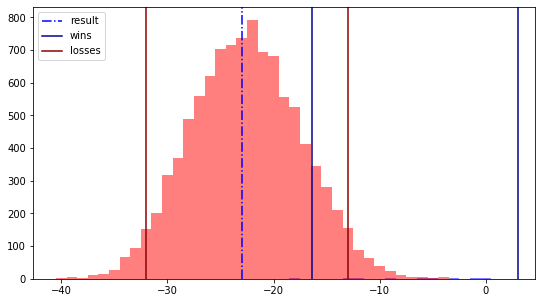

In [154]:
plt.rcParams['figure.figsize'] = [9, 5]

bootstraps['points_diff'] = bootstraps.points_won - bootstraps.points_lost
bootstraps['points_won_percentage'] = bootstraps.points_won / (bootstraps.points_won + bootstraps.points_lost)
wins = bootstraps[bootstraps.result == True]
losses = bootstraps[bootstraps.result == False]

confidence_wins = np.percentile(wins.points_diff, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_diff, [2.5, 97.5])

bins = np.arange(np.ptp(bootstraps.points_diff) + 1) - abs(bootstraps.points_diff.min()) - 0.5
_ = plt.hist(wins.points_diff, bins=bins, color='blue', alpha=0.5)
_ = plt.hist(losses.points_diff, bins=bins, color='red', alpha=0.5)


_ = plt.axvline(lucky_win.points_diff, linestyle='-.', color='blue', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='-', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='-', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='-', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='-', color='darkred')

_ = plt.legend()

In [159]:
odd_losses = odd_losses[~((odd_losses.score.str.contains('RET')) | (odd_losses.score.str.contains('DEF')))]
odd_losses.sort_values('points_won_percentage', ascending=False)[['player_name', 'score', 'points_diff', 'points_won_percentage']].head()

,,,player_name,score,points_diff,points_won_percentage
player_id,tournament_id,match_id,,,,
103105,2006-573,6.0,Ruben Ramirez Hidalgo,6-2 6-2,23.0,0.626374
100870,1991-375,20.0,Christo Van Rensburg,6-1 6-2,24.0,0.622449
104545,2008-315,3.0,John Isner,6-3 6-1,21.0,0.612903
109739,2018-540,144.0,Maximilian Marterer,6-3 6-2 6-4,24.0,0.574074
105062,2016-540,184.0,Mikhail Kukushkin,W/O,21.0,0.566879


In [168]:
unlucky_loss = odd_losses.loc[100870, '1991-375', 20.0]

fsp_p = unlucky_loss.first_serve_percentage
fsw_p = unlucky_loss.first_serves_won_percentage 
ssw_p = unlucky_loss.second_serves_won_percentage
fsp_o = (unlucky_loss.first_serve_return_points_won / unlucky_loss.first_serve_return_points_won_percentage) / unlucky_loss.return_points
fsw_o = 1 - unlucky_loss.first_serve_return_points_won_percentage
ssw_o = 1 - unlucky_loss.second_serve_return_points_won_percentage

bootstraps = pd.DataFrame.from_records(bootstrap_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, 10000),
                                       columns=['result', 'points_won', 'points_lost', 'games'])

bootstraps.result.sum() / bootstraps.result.size

0.9995

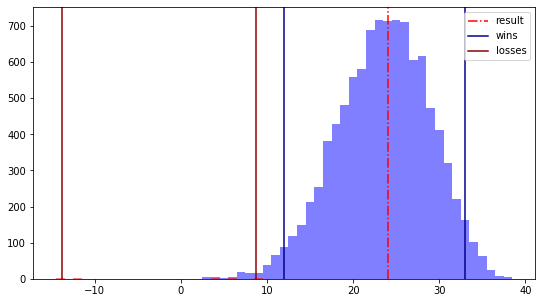

In [169]:
plt.rcParams['figure.figsize'] = [9, 5]

bootstraps['points_diff'] = bootstraps.points_won - bootstraps.points_lost
bootstraps['points_won_percentage'] = bootstraps.points_won / (bootstraps.points_won + bootstraps.points_lost)
wins = bootstraps[bootstraps.result == True]
losses = bootstraps[bootstraps.result == False]

confidence_wins = np.percentile(wins.points_diff, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_diff, [2.5, 97.5])

bins = np.arange(np.ptp(bootstraps.points_diff) + 1) - abs(bootstraps.points_diff.min()) - 0.5
_ = plt.hist(wins.points_diff, bins=bins, color='blue', alpha=0.5)
_ = plt.hist(losses.points_diff, bins=bins, color='red', alpha=0.5)


_ = plt.axvline(unlucky_loss.points_diff, linestyle='-.', color='red', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='-', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='-', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='-', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='-', color='darkred')

_ = plt.legend()